# Install necessary packages

In [ ]:
!pip install --user -r requirements.txt

# Imports

In [ ]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from IPython.display import Image, display

# Project Hyperparameters

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16
NUM_WORKERS = 1
NO_OF_IMAGE = 400

# Load and preprocess data

## Load data

In [ ]:
import time

start = time.time()

data_dir = 'sundatabasesubset'

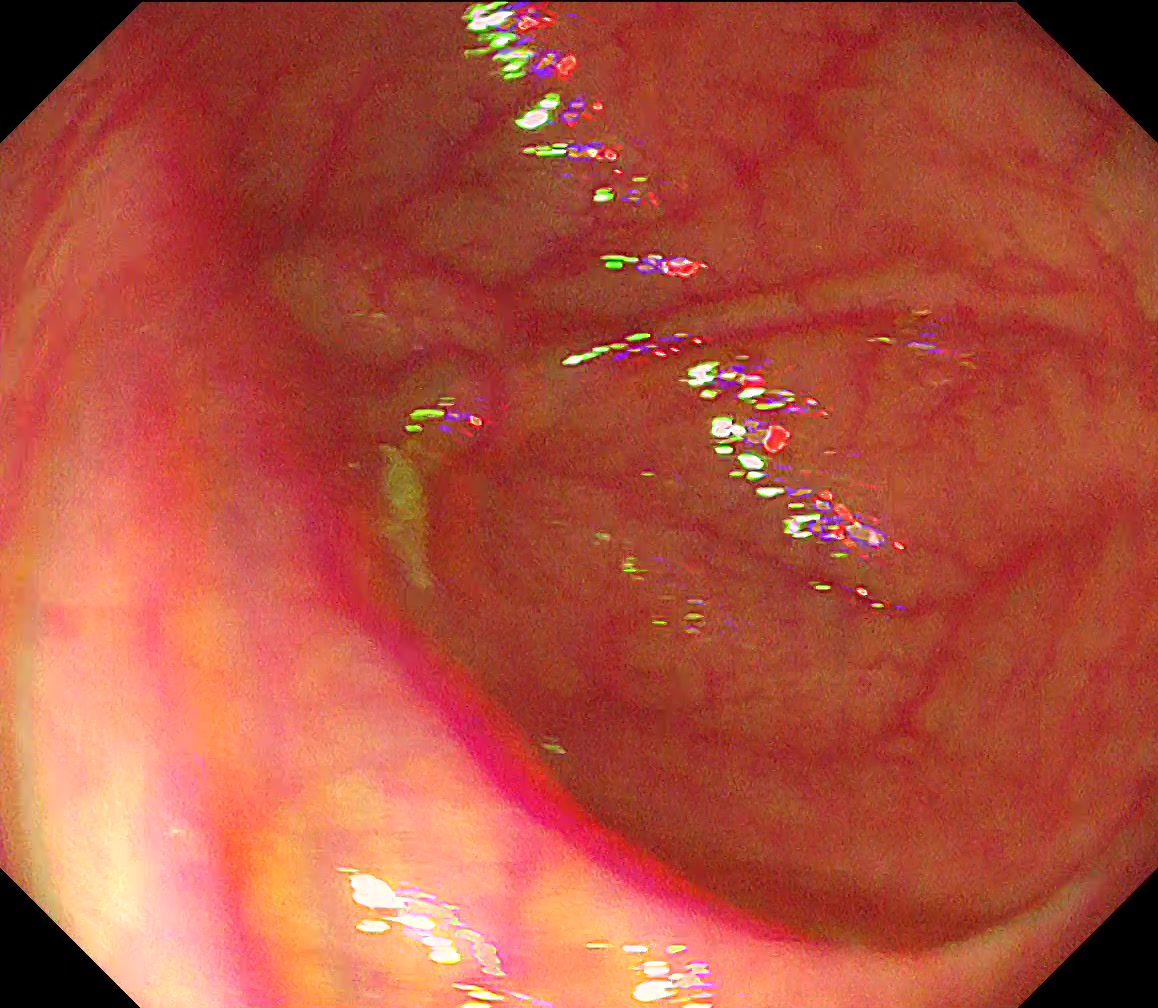

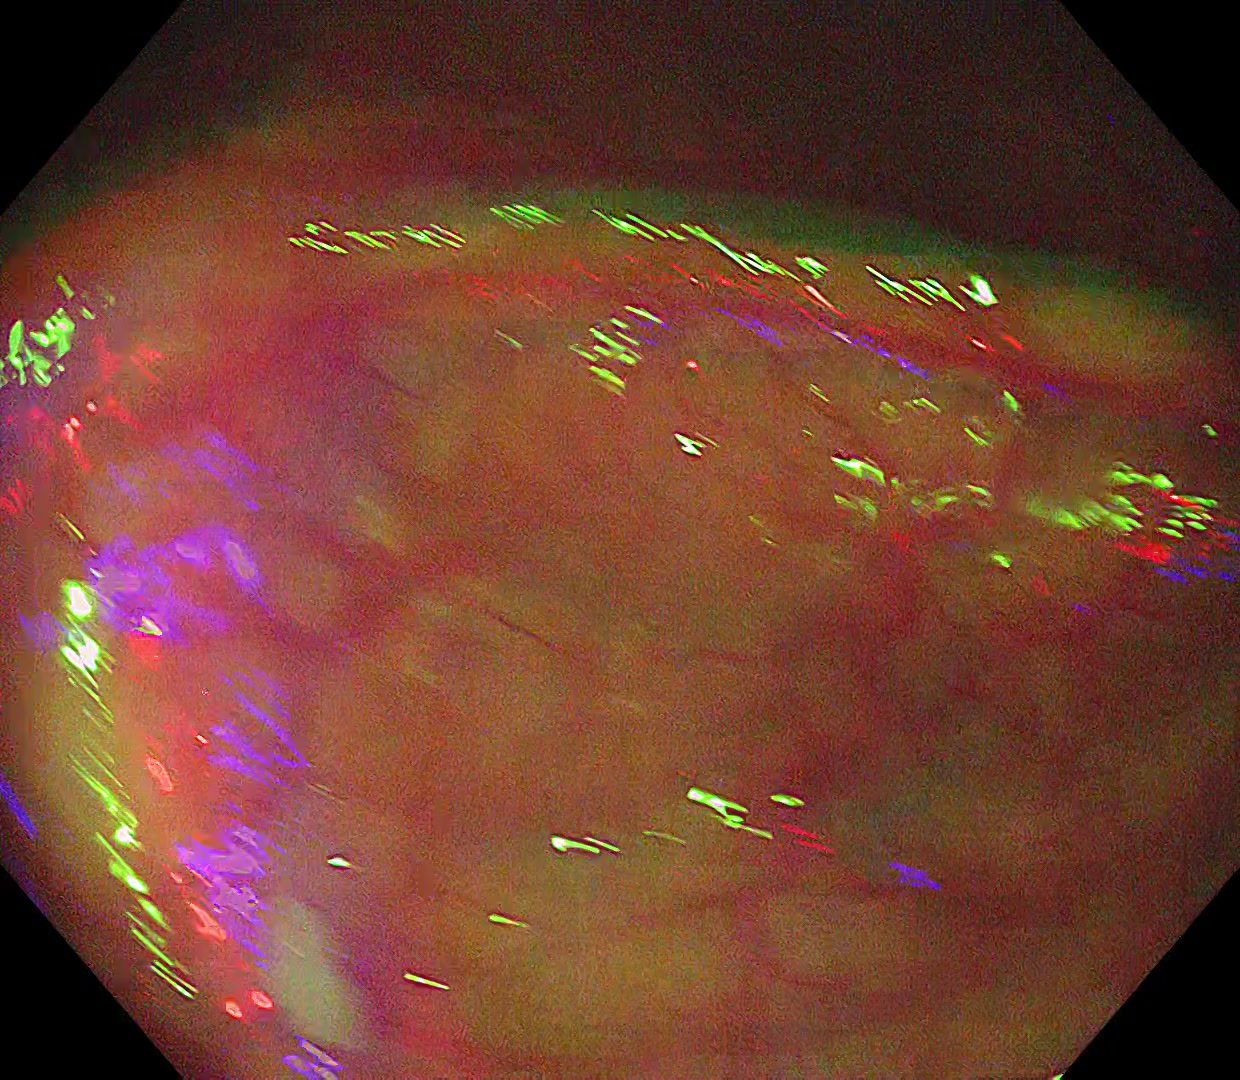

In [ ]:
display(Image(data_dir + '/positives/case_M_20181001100941_0U62372100109341_1_005_001-1_a2_ayy_image0039.jpg', width=224, height=224))
display(Image(data_dir + '/negatives/case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image000251.jpg', width=224, height=224))

## Preprocess data

In [ ]:
def load_split_train_val(datadir, valid_size = .2, no_of_image=int(NO_OF_IMAGE)):
    preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=preprocess)
    val_data = datasets.ImageFolder(datadir,
                    transform=preprocess)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * no_of_image))
    np.random.shuffle(indices)

    train_idx, val_idx = indices[split:split + (no_of_image - split) ], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=int(BATCH_SIZE), num_workers=int(NUM_WORKERS))
    valloader = torch.utils.data.DataLoader(val_data,
                   sampler=val_sampler, batch_size=int(BATCH_SIZE), num_workers=int(NUM_WORKERS))
    return trainloader, valloader, train_sampler, val_sampler

trainloader, valloader, train_sampler, val_sampler = load_split_train_val(data_dir, 0.2, int(NO_OF_IMAGE))
print(trainloader.dataset.classes)
print(len(train_sampler))
print(len(val_sampler))

320
80
['negatives', 'positives']


# Load and train the model

## Load model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())
model.to(device)

## Train model

In [ ]:
training_loss = []
validation_loss = []
def train_model(model, criterion, optimizer, num_epochs=int(EPOCHS)):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
                length = len(train_sampler)
            else:
                model.eval()
                dataloader = valloader
                length = len(val_sampler)

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / length
            epoch_acc = running_corrects.double() / length
            
            if phase == 'train':
                training_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model = train_model(model, criterion, optimizer, int(EPOCHS))
val_loss = validation_loss[-1]
end = time.time()
time_elapsed = end - start

In [ ]:
print(time_elapsed)
print(val_loss)